In [ ]:
from data import wiki
from data import corpus
import alignment

import nltk
import pandas as pd
import numpy as np
import pickle

from tqdm import tqdm_notebook as tqdm
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
%matplotlib inline

tqdm().pandas()

markers = alignment.load_markers()
markers_list = ['quantifiers', 'impersonal_pronouns','adverbs', 
    'articles', 'auxiliary_verbs', 'conjunctions',  
    'personal_pronouns', 'prepositions']

posts = wiki.load_posts()
posts = corpus.tokenize_posts(posts, lower_case=True, overwrite=False)
posts = corpus.detect_markers(posts, markers, overwrite=False)

pairs = corpus.get_reply_pairs(posts)
users = wiki.load_users(posts=posts)

wiki.save_posts(posts, overwrite=False)
wiki.save_users(users, overwrite=False)

Echoes of Power: given a set of exchanges $(u_a, u_b) \in U_{(A,b)}$ of user $b$ replying to users in group $A$, we define the coordination of $b$ _towards_ $A$ as:
$$
C^m(b,A) = P[\mathcal{E}_m(u_b) \mid \mathcal{E}_m(u_a)] - P[\mathcal{E}_m(u_b)]
$$

where $\mathcal{E}_m(u)$ means is $\mathtt{true}$ iff utterance $u$ exhibits marker $m$.

We estimate the probabilities as follows:
$$
\begin{align*}
P[\mathcal{E}_m(u_b)] &\approx \frac{|\{\mathcal{E}_m(u_b) \mid (u_a, u_b) \in {U_{(A,b)}}\}|}{|U_{A,b}|}\\
P[\mathcal{E}_m(u_b) \mid \mathcal{E}_m(u_a)] &\approx \frac{|\{\mathcal{E}_m(u_a)\land\mathcal{E}_m(u_b) \mid (u_a, u_b) \in {U_{(A,b)}}\}|}{|\{\mathcal{E}_m(u_a) \mid (u_a, u_b) \in {U_{(A,b)}}\}|}
\end{align*}
$$

In [2]:
posts['length'] = posts.tokens.apply(len)

# add users
df = posts.merge(users, left_on='user', right_index=True)

# binarize centrality
threshold = users.centrality.mean() + users.centrality.std()
df['highly_central'] = (df['centrality'] > threshold)
print("Threshold centrality: {}".format(threshold))

# merge into reply pairs
df = df.merge(df, left_index=True, right_on='reply_to', suffixes=('_a', '_b'))

Threshold centrality: 0.8344793851197967


In [3]:
markers_a = [m+'_a' for m in markers]
markers_b = [m+'_b' for m in markers]

In [4]:
def scp(groupA, df):
    
    groupA = groupA+'_a'
   
    # binarize marker presence
    ma = (df[markers_a] > 0).rename(dict(zip(markers_a, markers_list)), axis=1)
    mb = (df[markers_b] > 0).rename(dict(zip(markers_b, markers_list)), axis=1)
    mab = ma & mb

    ma[groupA], ma['user_b'] = df[groupA], df['user_b']
    mb[groupA], mb['user_b'] = df[groupA], df['user_b']
    mab[groupA], mab['user_b'] = df[groupA], df['user_b']
    
    a = ma.groupby([groupA, 'user_b']).sum()
    b = mb.groupby([groupA, 'user_b']).sum()
    ab = mab.groupby([groupA, 'user_b']).sum()
    total = df.groupby([groupA, 'user_b']).size()
    total = pd.concat([total] * len(markers), keys=markers_list, axis=1) # reshape to match others

    p_base = b.div(total)
    p_cond = ab.div(a)
    p_cond = p_cond.replace([np.inf, -np.inf], np.nan)
    
    scp = (p_cond - p_base)
    
    agg1 = scp.dropna().mean(axis=1)
    agg2 = scp.fillna(scp.mean(level=0)).mean(axis=1)
    agg3 = scp.transpose().fillna(scp.mean(axis=1)).transpose().mean(axis=1)
    scp['agg1'], scp['agg2'], scp['agg3'] = agg1, agg2, agg3
    
    return scp

In [5]:
admin_scp = scp('admin', df)
central_scp = scp('highly_central', df)

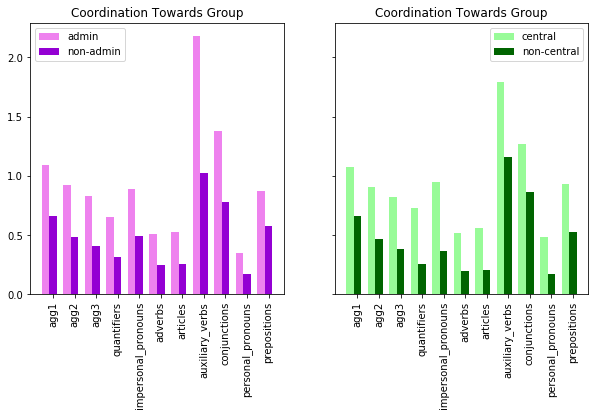

In [6]:
data = (admin_scp, central_scp)
labels = (['admin', 'non-admin'], ['central', 'non-central'])
colors = (['violet', 'darkviolet'], ['palegreen', 'darkgreen'])
groups = [True, False]
title = 'Coordination Towards Group'
stats = ['agg1', 'agg2', 'agg3'] + markers_list

fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(10,5))
ind = np.arange(len(stats))
width = 0.35

for ax, d, l, c in zip(axs, data, labels, colors):
    p = []
    for i, group in enumerate(groups):
        values = [d.mean(level=0).loc[group].loc[m] * 100 for m in stats]
        p.append(ax.bar(ind+i*width, list(values), width=width, color=c[i]))
    ax.legend((p[i][0] for i in range(len(p))), l)
    ax.set_title(title)
    ax.set_xticklabels(stats)
    ax.set_xticks(ind+width)
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)

# WSCP

Word-based SCP is similar to SCP, but instead of
comparing the probability of $u_b$ exhibiting $m$,
we compare the probability that a given word $w$ in
$u_b$ is in $m$ (the set of words constituting the marker).

Coordination of user $b$ towards group $A$ is defined:
$$
C^m(b,A) = P[w_b \in m \mid \mathcal{E}_m(u_a)] - P[w_b\in m]
$$

Where $P[w_b \in m \mid \mathcal{E}_m(u_a)]$ is estimated by the frequency of $m$ tokens over all posts in $\{(u_a,u_b)\in U_{(a,b)}\mid \mathcal{E}_m(u_a)\}$

And $P[w_b \in m]$ is estimated by the frequency of $m$ tokens in all posts by $b$ (not just those in $U_{a,b}$).

In [7]:
def wscp(posts, df, groupA):
    
    def base_prob_m(m):

        base_m_count = posts.groupby('user')[m].sum()
        base_word_count = posts.groupby('user')['length'].sum()
        base_prob = base_m_count / base_word_count
        return base_prob

    def cond_prob_m(m):
        cond_m_count = df[ma_bin[m]].groupby([groupA+'_a', 'user_b'])[m+'_b'].sum()
        cond_word_count = df[ma_bin[m]].groupby([groupA+'_a', 'user_b'])['length_b'].sum()
        cond_prob = cond_m_count / cond_word_count
        return cond_prob

    ma_bin = (df[markers_a] > 0).rename(dict(zip(markers_a, markers_list)), axis=1)
    base_prob = pd.DataFrame({m: base_prob_m(m) for m in markers})
    cond_prob = pd.DataFrame({m: cond_prob_m(m) for m in markers})
    
    wscp = cond_prob.subtract(base_prob, level=1)
    
    agg1 = wscp.dropna().mean(axis=1)
    agg2 = wscp.fillna(wscp.mean(level=0)).mean(axis=1)
    agg3 = wscp.transpose().fillna(wscp.mean(axis=1)).transpose().mean(axis=1)
    wscp['agg1'], wscp['agg2'], wscp['agg3'] = agg1, agg2, agg3
    
    return wscp

In [8]:
admin_wscp = wscp(posts, df, 'admin')
central_wscp = wscp(posts, df, 'highly_central')

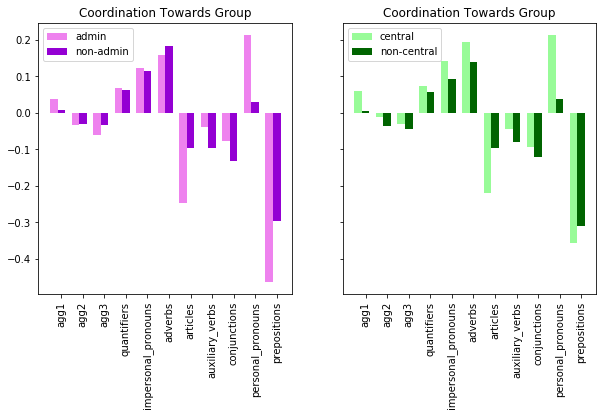

In [9]:
data = (admin_wscp, central_wscp)
labels = (['admin', 'non-admin'], ['central', 'non-central'])
colors = (['violet', 'darkviolet'], ['palegreen', 'darkgreen'])
groups = [True, False]
title = 'Coordination Towards Group'
stats = ['agg1', 'agg2', 'agg3'] + markers_list

fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(10,5))
ind = np.arange(len(stats))
width = 0.35

for ax, d, l, c in zip(axs, data, labels, colors):
    p = []
    for i, group in enumerate(groups):
        values = [d.mean(level=0).loc[group].loc[m] * 100 for m in stats]
        p.append(ax.bar(ind+i*width, list(values), width=width, color=c[i]))
    ax.legend((p[i][0] for i in range(len(p))), l)
    ax.set_title(title)
    ax.set_xticklabels(stats)
    ax.set_xticks(ind+width)
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)

# Correlation with centrality

How much does a user's centrality correlate with their degree of style coordination with different groups?


## SCP

In [55]:
import scipy.stats as stats

print("Correlation between SCP coordination given & centrality")
for admin in(True, False):
    print("Coordination given to {}admins".format('' if admin else "non-"))
    print(20*" " +"{:6}   {:6}".format("r", "p-value"))
    a = admin_scp.loc[admin]
    a['centrality'] = users['centrality']
    for m in markers_list + ['agg1', 'agg2', 'agg3']:
        b = a[['centrality', m]].dropna()
        r, p_value = stats.pearsonr(b['centrality'], b[m])
        print("{:20}{:.5f}  {:.5f}".format(m,r, p_value))
    print()

Correlation between SCP coordination given & centrality
Coordination given to admins
                    r        p-value
quantifiers         0.04149  0.00022
impersonal_pronouns 0.02912  0.00973
adverbs             0.04793  0.00001
articles            0.02445  0.02813
auxiliary_verbs     0.03248  0.01055
conjunctions        0.05119  0.00001
personal_pronouns   0.03419  0.00209
prepositions        0.05226  0.00000
agg1                0.07086  0.00000
agg2                0.06943  0.00000
agg3                0.07659  0.00000

Coordination given to non-admins
                    r        p-value
quantifiers         0.03076  0.00046
impersonal_pronouns 0.03901  0.00001
adverbs             0.02228  0.00995
articles            0.01411  0.10582
auxiliary_verbs     0.05493  0.00000
conjunctions        0.05165  0.00000
personal_pronouns   0.02888  0.00089
prepositions        0.03777  0.00001
agg1                0.07804  0.00000
agg2                0.06405  0.00000
agg3                0.06963  0

In [54]:
print("Correlation between SCP coordination given & centrality")
for central in(True, False):
    print("Coordination given to {}central users".format('' if central else "non-"))
    print(20*" " +"{:6}   {:6}".format("r", "p-value"))
    a = central_scp.loc[central]
    a['centrality'] = users['centrality']
    for m in markers_list + ['agg1', 'agg2', 'agg3']:
        b = a[['centrality', m]].dropna()
        r, p_value = stats.pearsonr(b['centrality'], b[m])
        print("{:20}{:.5f}  {:.5f}".format(m,r, p_value))
    print()

Correlation between SCP coordination given & centrality
Coordination given to central users
                    r        p-value
quantifiers         0.04170  0.00008
impersonal_pronouns 0.04045  0.00015
adverbs             0.04306  0.00003
articles            0.02741  0.00914
auxiliary_verbs     0.03553  0.00297
conjunctions        0.05774  0.00000
personal_pronouns   0.01922  0.06567
prepositions        0.03926  0.00018
agg1                0.06628  0.00000
agg2                0.06868  0.00000
agg3                0.07640  0.00000

Coordination given to non-central users
                    r        p-value
quantifiers         0.03258  0.00029
impersonal_pronouns 0.03157  0.00049
adverbs             0.02064  0.01985
articles            0.01403  0.11658
auxiliary_verbs     0.05734  0.00000
conjunctions        0.05696  0.00000
personal_pronouns   0.02970  0.00087
prepositions        0.04418  0.00000
agg1                0.08008  0.00000
agg2                0.06725  0.00000
agg3            

## WSCP

In [56]:
import scipy.stats as stats

print("Correlation between WSCP coordination given & centrality")
for admin in(True, False):
    print("Coordination given to {}admins".format('' if admin else "non-"))
    print(20*" " +"{:6}   {:6}".format("r", "p-value"))
    a = admin_wscp.loc[admin]
    a['centrality'] = users['centrality']
    for m in markers_list + ['agg1', 'agg2', 'agg3']:
        b = a[['centrality', m]].dropna()
        r, p_value = stats.pearsonr(b['centrality'], b[m])
        print("{:20}{:.5f}  {:.5f}".format(m,r, p_value))
    print()

Correlation between WSCP coordination given & centrality
Coordination given to admins
                    r        p-value
quantifiers         0.02156  0.05464
impersonal_pronouns 0.02444  0.03001
adverbs             0.02674  0.01514
articles            0.02937  0.00836
auxiliary_verbs     0.03178  0.01234
conjunctions        0.00482  0.67519
personal_pronouns   0.00223  0.84093
prepositions        0.05382  0.00000
agg1                0.05792  0.00001
agg2                0.05354  0.00000
agg3                0.05000  0.00000

Coordination given to non-admins
                    r        p-value
quantifiers         0.01078  0.21968
impersonal_pronouns 0.01704  0.05373
adverbs             0.01663  0.05445
articles            0.02455  0.00489
auxiliary_verbs     0.02017  0.03926
conjunctions        -0.00404  0.65260
personal_pronouns   0.01129  0.19436
prepositions        0.00392  0.65319
agg1                0.04369  0.00002
agg2                0.02754  0.00124
agg3                0.02035 

In [58]:
print("Correlation between WSCP coordination given & centrality")
for central in(True, False):
    print("Coordination given to {}central users".format('' if central else "non-"))
    print(20*" " +"{:6}   {:6}".format("r", "p-value"))
    a = central_wscp.loc[central]
    a['centrality'] = users['centrality']
    for m in markers_list + ['agg1', 'agg2', 'agg3']:
        b = a[['centrality', m]].dropna()
        r, p_value = stats.pearsonr(b['centrality'], b[m])
        print("{:20}{:.5f}  {:.5f}".format(m,r, p_value))
    print()

Correlation between WSCP coordination given & centrality
Coordination given to central users
                    r        p-value
quantifiers         0.01576  0.13654
impersonal_pronouns 0.02980  0.00514
adverbs             0.02758  0.00803
articles            0.05379  0.00000
auxiliary_verbs     0.03598  0.00263
conjunctions        0.01137  0.29476
personal_pronouns   -0.01440  0.16792
prepositions        0.05710  0.00000
agg1                0.06067  0.00000
agg2                0.05830  0.00000
agg3                0.05574  0.00000

Coordination given to non-central users
                    r        p-value
quantifiers         0.00899  0.31800
impersonal_pronouns 0.00801  0.37608
adverbs             0.00855  0.33489
articles            0.02218  0.01312
auxiliary_verbs     0.02791  0.00536
conjunctions        -0.01095  0.23462
personal_pronouns   0.00893  0.31712
prepositions        0.00171  0.84814
agg1                0.03764  0.00030
agg2                0.02036  0.01996
agg3         